In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy as sc

In [2]:
def unitcell_leads(w,d,t,e,l):
    n = l
    H = (w + 1J * d - e) * np.eye(n,dtype=complex)
    # set nearest-neighbour (adjacent) hopping terms
    ind = np.arange(0, n-1, 1)
    H[ind, ind+1] = t
    H[ind+1, ind] = t
    
    return H


In [3]:
def leads(w,d,t,e,l): 
    
    unit = np.linalg.inv(unitcell_leads(w,d,t,e,l))
    hopp = np.eye(l,dtype=complex)
    diff = 0.01
    G = unit.copy()
    g = unit.copy()
    iden = np.eye(l,dtype=complex)

    g_hopp = g @ hopp


    while diff >0.000001:
        A = iden -g_hopp @ G @ hopp
        G_new = np.linalg.solve(A, g)
        diff = np.max(np.abs(np.trace(G_new - G)))

        G = G_new

    return G


In [ ]:
[]

In [4]:
from joblib import Parallel, delayed
import os
for l in np.arange(5,51,5):
    def compute_and_save(w):
        G = leads(w, 0.0001, 1, 0, l)
        fn = os.path.expanduser(f'~/Desktop/backup/leads/leads_{l}_w_{w:.2f}.csv')
        np.savetxt(fn, G, delimiter=',')
        return w

    ws = np.arange(0, 4, 0.01)
    Parallel(n_jobs=-1)(delayed(compute_and_save)(w) for w in ws)

In [ ]:
def computed_leads(l):
    leads = {}
    for w in np.arange(0, 4,0.01):
    
        fn = os.path.expanduser(f'~/Desktop/backup/leads/leads_{l}_w_{w:.2f}.csv')
        if os.path.exists(fn):
            leads[w] = np.loadtxt(fn, delimiter=',', dtype=complex)
    return leads

In [70]:
leads.keys()

dict_keys([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1300000000000001, 1.1400000000000001, 1.1500000000000001, 1.16, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1

In [7]:
ldos = []
for w in np.arange(0,4,0.01):
    ldos.append(-np.imag(leads[w][0,0]))

TypeError: 'function' object is not subscriptable

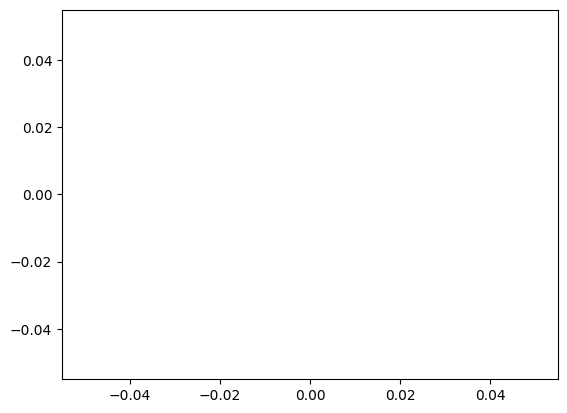

In [8]:
plt.plot(ldos)

In [ ]:
def device(w,d,t,e,l):
#    lead = leads[w]
    hopp = np.eye(l,dtype=complex)
    unit = np.linalg.inv(unitcell_leads(w,d,t,e,l))
#    G = unit.copy()
    g = unit.copy()
    iden = np.eye(l,dtype=complex)

    G= leads[w]

    g_hopp = g @ hopp
    for _ in range(100):
        A = iden -g @hopp  @ G @ hopp
        G_new = np.linalg.solve(A, g)
        G = G_new
    
    left_device = G_new
    right = leads[w]
    ##connect left to right lead##
    c_l_1 =iden -right@ hopp @ left_device @ hopp
    c_l = np.linalg.solve(c_l_1, left_device)
    c_l_2 = iden - left_device @ hopp @ right @ hopp
    c_r = np.linalg.solve(c_l_2, right)

    ##transmission and greens functions##

    G_ll = c_l  - np.transpose(np.conjugate(c_l ))
    G_rr = c_r - np.transpose(np.conjugate(c_r))

    G_lr = left_device @ hopp @ c_r
    Gnon = G_lr - np.transpose(np.conjugate(G_lr))



    tr1 = G_ll @ hopp @ G_rr @hopp - hopp@Gnon @hopp @Gnon
#    inl,hop,inr,hop - np.linalg.multi_dot([hop,gnon,hop,gnon])
    tr2 = np.trace(tr1).sum()

    return np.abs(tr2)

In [85]:
device(0,0.0001,1,0,60)

59.99922908526459

In [86]:
cond = []
for w in np.arange(0,4,0.01):
    cond.append(device(w,0.0001,1,0,60))

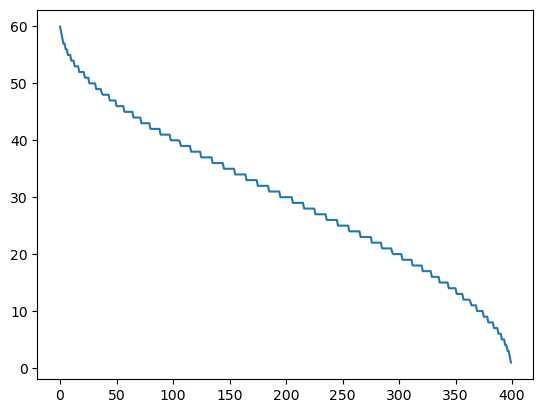

In [87]:
plt.plot(cond)

In [65]:
dos = []
for w in np.arange(0,4,0.01):
    left = leads[w]
    right = leads[w]
    iden = np.eye(10,dtype=complex)
    hopp = np.eye(10,dtype=complex)
    dev = iden - left@hopp@right@hopp
    c_l = np.linalg.solve(dev, left)
    dos.append(-np.imag(c_l[0,0]))

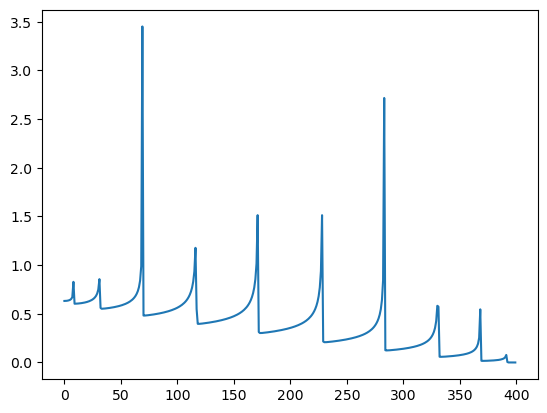

In [66]:
plt.plot(dos)

In [179]:
def possible_combs(n,width):
    def combs(n,x):
        np.random.seed(x)
        device_combs = [(i, j) for i in range(100) for j in range(width)]
        chosen_indices = np.random.choice(len(device_combs), size=n, replace=False)
    
        return sorted([device_combs[idx] for idx in chosen_indices])
    return np.array([combs(n,x) for x in range(10000)])

In [ ]:
combs[]

In [ ]:
def leads(w,d,t,e,l): 
    
    unit = np.linalg.inv(unitcell_leads(w,d,t,e,l))
    hopp = np.eye(l,dtype=complex)
    diff = 0.01
    G = unit.copy()
    g = unit.copy()
    iden = np.eye(l,dtype=complex)

    g_hopp = g @ hopp


    while diff >0.000001:
        A = iden -g_hopp @ G @ hopp
        G_new = np.linalg.solve(A, g)
        diff = np.max(np.abs(np.trace(G_new - G)))

        G = G_new

    return G


In [191]:
def device(w,d,t,e,l,config,n):
#    lead = leads[w]
    hopp = np.eye(l,dtype=complex)
    unit = np.linalg.inv(unitcell_leads(w,d,t,e,l))
#    G = unit.copy()
    g = unit.copy()
    iden = np.eye(l,dtype=complex)

    G = computed_leads(l)[w]

    g_hopp = g @ hopp
    for x in range(100):
        g_d = np.linalg.inv(unidevice(w,d,t,e,l,config,n,x))
        A = iden -g_d @hopp  @ G @ hopp
        G_new = np.linalg.solve(A, g_d)
        G = G_new
    
    left_device = G_new
    right = computed_leads(l)[w]
    ##connect left to right lead##
    c_l_1 =iden - right@ hopp @ left_device @ hopp
    c_l = np.linalg.solve(c_l_1, left_device)
    c_l_2 = iden - left_device @ hopp @ right @ hopp
    c_r = np.linalg.solve(c_l_2, right)

    ##transmission and greens functions##

    G_ll = c_l  - np.transpose(np.conjugate(c_l ))
    G_rr = c_r - np.transpose(np.conjugate(c_r))

    G_lr = left_device @ hopp @ c_r
    Gnon = G_lr - np.transpose(np.conjugate(G_lr))


    tr1 = G_ll @ hopp @ G_rr @hopp - hopp@Gnon @hopp @Gnon
#    inl,hop,inr,hop - np.linalg.multi_dot([hop,gnon,hop,gnon])
    tr2 = np.trace(tr1).sum()

    return np.abs(tr2)

In [ ]:

for n in np.arange(5,50,5):
    def compute_and_save(config):
        G = [device(w,0.0001,1,0,20,config,n) for w in np.arange(0,4,0.01)]
        fn = os.path.expanduser(f'~/Desktop/transmissions/lead_size_{20}_conc_{n}_config_{config:.2f}.csv')
        np.savetxt(fn, G, delimiter=',')
        return config

    
    Parallel(n_jobs=-1)(delayed(compute_and_save)(config) for config in range(10000))

KeyboardInterrupt: 

In [193]:
[device(w,0.0001,1,0,20,1,10) for w in np.arange(0,4,0.01)]

KeyboardInterrupt: 

In [194]:
device(0,0.0001,1,0,20,1,10)

5.516194654815131